# Twin4Build: CO2 Controller Example

This notebook demonstrates how to use the Twin4Build package to create and simulate a CO2 controller model for a building space. We'll go through the process step-by-step, explaining each part along the way.

## 1. Import Required Libraries

First, we import the necessary libraries and modules.

In [29]:
# %pip install twin4build # Uncomment in google colab
import datetime
from dateutil import tz
import twin4build as tb


## 2. Define Model Components and Connections

Now we define the components of our CO2 controller model and their connections.<br>
For convenience, we can pack all these definitions into the "fcn" function, which will be used to create the model.

In [30]:
def fcn(self):
    ##############################################################
    ################## First, define components ##################
    ##############################################################
    occupancy_schedule = tb.ScheduleSystem(
        weekDayRulesetDict={
            "ruleset_default_value": 0,
            "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
            "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
            "ruleset_start_hour": [6, 7, 8, 12, 14, 16, 18],
            "ruleset_end_hour": [7, 8, 12, 14, 16, 18, 22],
            "ruleset_value": [3, 5, 20, 25, 27, 7, 3]},
        add_noise=True,
        id="OccupancySchedule")
    
    co2_setpoint_schedule = tb.ScheduleSystem(
        weekDayRulesetDict={
            "ruleset_default_value": 900,
            "ruleset_start_minute": [],
            "ruleset_end_minute": [],
            "ruleset_start_hour": [],
            "ruleset_end_hour": [],
            "ruleset_value": []},
        id="CO2SetpointSchedule")
    
    outdoor_co2 = tb.ScheduleSystem(
        weekDayRulesetDict={
            "ruleset_default_value": 400,
            "ruleset_start_minute": [],
            "ruleset_end_minute": [],
            "ruleset_start_hour": [],
            "ruleset_end_hour": [],
            "ruleset_value": []},
        id="outdoorCO2")

    co2_controller = tb.PIDControllerSystem(
        kp=0.001,
        Ti=0.001,
        isReverse=False,
        id="CO2Controller")

    supply_damper = tb.DamperTorchSystem(
        nominalAirFlowRate=1.6,
        a=5,
        id="SupplyDamper")

    return_damper = tb.DamperTorchSystem(
        nominalAirFlowRate=1.6,
        a=5,
        id="ExhaustDamper")

    space = tb.BuildingSpaceMassTorchSystem(
        # Space parameters
        V=100,
        G_occ=1e-5,
        m_inf=100*1.225/3600,
        id="Space"
    )

    #################################################################
    ################## Add connections to the model #################
    #################################################################
    self.add_connection(co2_controller, supply_damper,
                         "inputSignal", "damperPosition")
    self.add_connection(co2_controller, return_damper,
                         "inputSignal", "damperPosition")
    self.add_connection(supply_damper, space,
                         "airFlowRate", "supplyAirFlowRate")
    self.add_connection(return_damper, space,
                         "airFlowRate", "exhaustAirFlowRate")
    self.add_connection(occupancy_schedule, space,
                         "scheduleValue", "numberOfPeople")
    self.add_connection(outdoor_co2, space,
                        "scheduleValue", "outdoorCO2")
    self.add_connection(space, co2_controller,
                         "indoorCO2", "actualValue")
    self.add_connection(co2_setpoint_schedule, co2_controller,
                         "scheduleValue", "setpointValue")

## 3. Create and Load the Model

Now we create a model instance and load it with the components and connections we defined.<br>
You can compare the shown graph and model structure with the one we defined in "fcn" function as part of the previous step.

In [31]:
model = tb.Model(id="co2_control")
model.load(fcn=fcn, verbose=False)
# system_graph = os.path.join(model.graph_path, "system_graph.png")
# image = plt.imread(system_graph)
# plt.figure(figsize=(12,12))
# plt.imshow(image)
# plt.axis('off')
# plt.show()

[OK]
   |   |   |___Loading model...[OK]
   |   |   |   |
   |   |   |   |___Drawing simulation model...
Loading model...[OK]
   |___Applying user defined function...[OK]
   |___Removing cycles...[OK]
   |___Determining execution order...[OK]
   |___Loading parameters...[OK]
   |___Validating model...[OK]
   |   |
   |
   |___Validated for Simulator...OK
   |___Validated for Estimator...OK
   |___Validated for Evaluator...OK
   |___Validated for Monitor...OK
   |___

+----------------------------------------------------------------------------+
|             Model overview    id: co2_control_simulation_model             |
+---------------------------------------------+------------------------------+
|  Number of components in simulation model:  |              7               |
+---------------------------------------------+------------------------------+
| Number of connections in simulation model:  |              16              |
+---------------------------------------------+-------

## 4. Set Up Simulation Parameters and Run Simulation

We set up the simulation parameters and run the simulation for our CO2 controller model.

In [32]:
simulator = tb.Simulator(model)
step_size = 600 #Seconds
start_time = datetime.datetime(year=2024, month=1, day=10, hour=0, minute=0, second=0, tzinfo=tz.gettz("Europe/Copenhagen"))
end_time = datetime.datetime(year=2024, month=1, day=12, hour=0, minute=0, second=0, tzinfo=tz.gettz("Europe/Copenhagen"))

# Simulate the model
simulator.simulate(step_size=step_size,
                    start_time = start_time,
                    end_time = end_time)

100%|██████████| 288/288 [00:00<00:00, 2016.53it/s]


## 5. Visualize Results

We use the built-in plotting functions to visualize the simulation results.

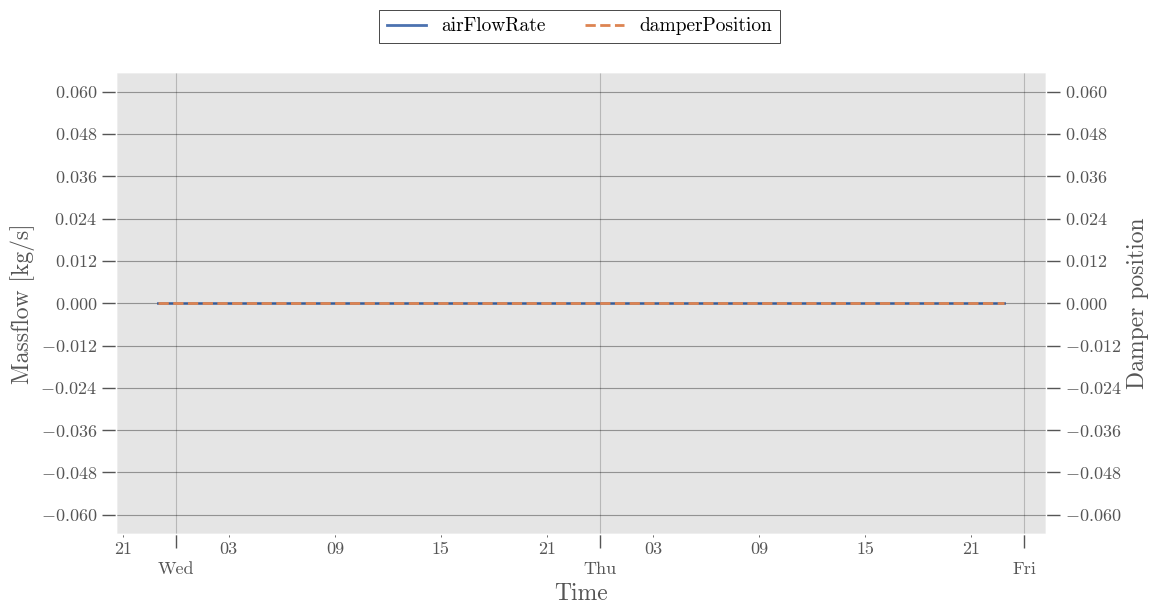

(<Figure size 1200x600 with 2 Axes>,
 [<Axes: xlabel='Time', ylabel='Massflow [kg/s]'>,
  <Axes: ylabel='Damper position'>])

In [33]:
import twin4build.utils.plot.plot as plot
plot.plot_component(simulator, 
                    components_1axis=[(model.components["SupplyDamper"], "airFlowRate", "output")],
                    components_2axis=[(model.components["ExhaustDamper"], "damperPosition", "input")],
                    ylabel_1axis="Massflow [kg/s]", #Optional
                    ylabel_2axis="Damper position", #Optional
                    show=True, 
                    align_zero=True,
                    nticks=11)

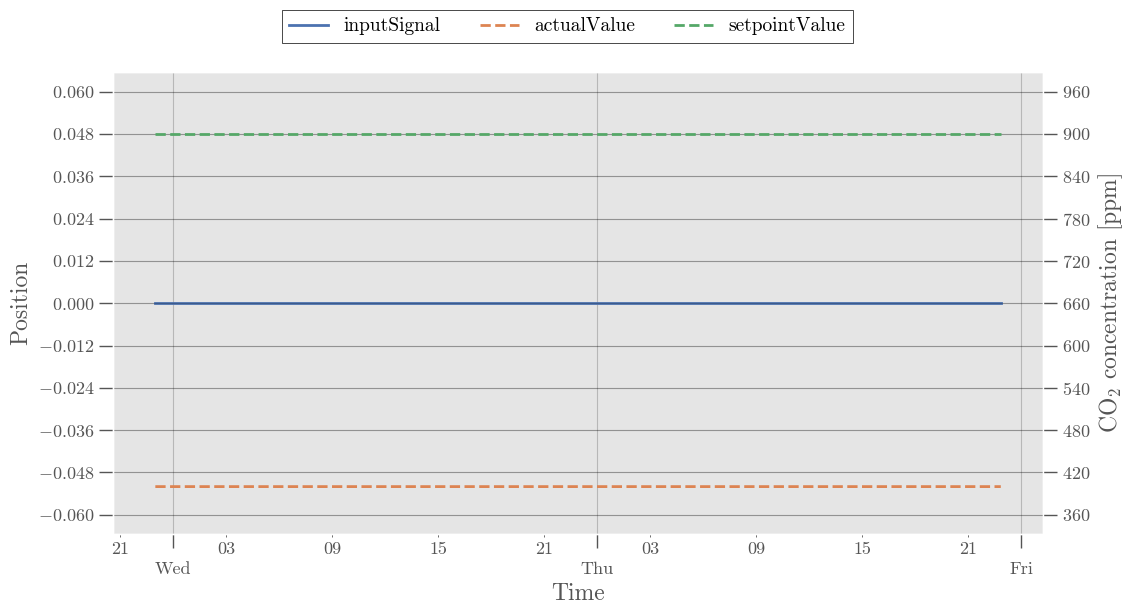

(<Figure size 1200x600 with 2 Axes>,
 [<Axes: xlabel='Time', ylabel='Position'>,
  <Axes: ylabel='CO$_2$ concentration [ppm]'>])

In [34]:
plot.plot_component(simulator, 
                    components_1axis=[(model.components["CO2Controller"], "inputSignal", "output")], 
                    components_2axis=[(model.components["CO2Controller"], "actualValue", "input"), 
                                      (model.components["CO2Controller"], "setpointValue", "input")],
                    ylabel_1axis="Position", #Optional
                    ylabel_2axis=r"CO$_2$ concentration [ppm]", #Optional
                    show=True,
                    nticks=11)

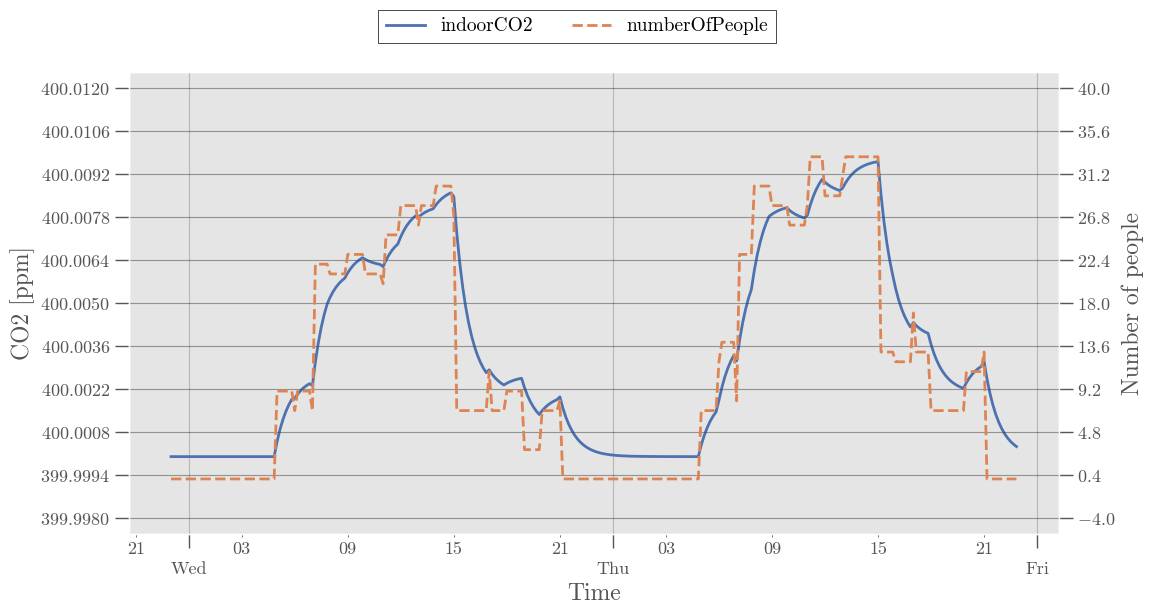

(<Figure size 1200x600 with 2 Axes>,
 [<Axes: xlabel='Time', ylabel='CO2 [ppm]'>,
  <Axes: ylabel='Number of people'>])

In [35]:
plot.plot_component(simulator, 
                    components_1axis=[(model.components["Space"], "indoorCO2", "output")], 
                    components_2axis=[(model.components["Space"], "numberOfPeople", "input")],
                    ylabel_1axis="CO2 [ppm]",
                    ylabel_2axis="Number of people", #Optional
                    show=True, 
                    align_zero=True,
                    nticks=11)

## 6. Interpreting the Results

The plots show:

1. Supply Damper Position: This graph illustrates how the damper position and airflow changes over time in response to CO2 levels.

2. CO2 Controller: This plot shows the actual CO2 concentration compared to the setpoint, and the controller output (green line).

These visualizations help us understand how the CO2 controller is managing the indoor air quality based on occupancy and setpoints.

## 7. Next Steps

To further explore this model, you could:
- Adjust the PID controller parameters to see how they affect the system response
- Modify the occupancy schedule to simulate different usage patterns
- Change the CO2 setpoint to observe its impact on ventilation behavior

This example demonstrates the power of Twin4Build for modeling and simulating building control systems.